# Detectron2 Beginner's Tutorial

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2! This is the official colab tutorial of detectron2. Here, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset

You can make a copy of this tutorial by "File -> Open in playground mode" and make changes there. __DO NOT__ request access to this tutorial.


# Install detectron2

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'

dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebokresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 1.7 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15528, done.
remote: Counting objects: 100% (253/253), done.
remote: Compressing objects: 100% (211/211), done.
remote: Total 15528 (delta 82), reused 185 (delta 42), pack-reused 15275
Receiving objects: 100% (15528/15528), 6.40 MiB | 10.67 MiB/s, done.
Resolving deltas: 100% (11197/11197), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.2 MB/s eta 0:00:

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

In [ ]:

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Train on a custom dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the balloon segmentation dataset](https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon)
which only has one class: balloon.
We'll train a balloon segmentation model from an existing model pre-trained on COCO dataset, available in detectron2's model zoo.

Note that COCO dataset does not have the "balloon" category. We'll be able to recognize this new class in a few minutes.

## Prepare the dataset

Register the balloon dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. User should write such a function when using a dataset in custom format. See the tutorial for more details.


In [ ]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("dataset_train6", {}, "/content/drive/MyDrive/P2M/dataset/new_train_data.json", "/content/drive/MyDrive/P2M/dataset")


In [ ]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("validation_dataset3", {}, "/content/drive/MyDrive/P2M/dataset/val_dataset.json", "/content/drive/MyDrive/P2M/dataset/val")


To verify the dataset is in correct format, let's visualize the annotations of randomly selected samples in the training set:



## Train!

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~2 minutes to train 300 iterations on a P100 GPU.


In [ ]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2 import model_zoo

# Load the configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))

# Other configuration options...
cfg.DATASETS.TRAIN = ("dataset_train6")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS =model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025  # Starting learning rate
cfg.SOLVER.GAMMA = 0.1        # Factor to reduce the learning rate by at each step
cfg.SOLVER.STEPS = (7000, 9000)  # Points where the learning rate will decay. Adjust based on your MAX_ITER.
cfg.SOLVER.MAX_ITER = 10000
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 250
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6

# Create the output directory if it doesn't exist
cfg.OUTPUT_DIR = '/content/drive/MyDrive/P2M/dataset/faster_rcnn_R_101_FPN_3x'
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# cfg.MODEL.DEVICE = 'cpu'

# Create the DefaultTrainer
trainer = DefaultTrainer(cfg)

trainer.resume_or_load(resume=False)

# Start training
trainer.train()

[04/02 20:05:41 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
model_final_f6e8b1.pkl: 243MB [00:01, 138MB/s]                            
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[04/02 20:05:45 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/02 20:06:17 d2.utils.events]:  eta: 3:48:18  iter: 19  total_loss: 3.136  loss_cls: 2.021  loss_box_reg: 0.8171  loss_rpn_cls: 0.1756  loss_rpn_loc: 0.07584    time: 1.3332  last_time: 1.4450  data_time: 0.1291  last_data_time: 0.0215   lr: 4.9953e-06  max_mem: 6543M
[04/02 20:06:47 d2.utils.events]:  eta: 3:47:51  iter: 39  total_loss: 2.973  loss_cls: 1.906  loss_box_reg: 0.824  loss_rpn_cls: 0.1477  loss_rpn_loc: 0.08689    time: 1.3538  last_time: 1.1601  data_time: 0.0274  last_data_time: 0.0409   lr: 9.9902e-06  max_mem: 6683M
[04/02 20:07:15 d2.utils.events]:  eta: 3:47:52  iter: 59  total_loss: 2.695  loss_cls: 1.694  loss_box_reg: 0.8551  loss_rpn_cls: 0.06984  loss_rpn_loc: 0.07874    time: 1.3553  last_time: 1.1850  data_time: 0.0283  last_data_time: 0.0474   lr: 1.4985e-05  max_mem: 6683M
[04/02 20:07:44 d2.utils.events]:  eta: 3:51:25  iter: 79  total_loss: 2.412  loss_cls: 1.386  loss_box_reg: 0.8171  loss_rpn_cls: 0.08952  loss_rpn_loc: 0.08026    time: 1.3901  last_

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [ ]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6  # Set the number of classes based on your dataset
# Make sure cfg.MODEL.WEIGHTS points to the path of your saved model
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/P2M/dataset/faster_rcnn_R_50_FPN_3x/more_iterations.yaml/model_final.pth"

# Set the testing threshold for this model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6 # Adjust this threshold as needed.
cfg.MODEL.DEVICE = 'cpu'
# Create a predictor object with the configuration
predictor = DefaultPredictor(cfg)

[04/02 01:03:14 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/P2M/dataset/faster_rcnn_R_50_FPN_3x/more_iterations.yaml/model_final.pth ...


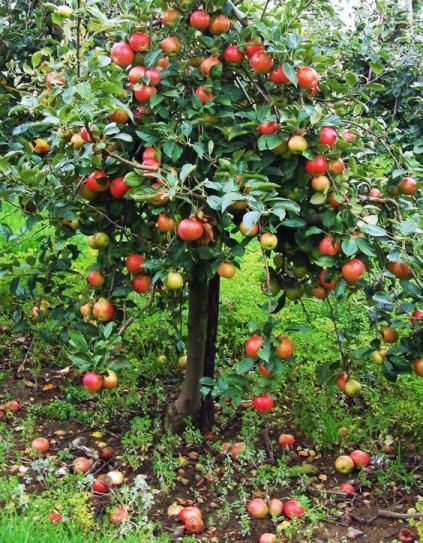

In [ ]:
import cv2
# Replace with the path to your test image
# test_image_path = "/content/drive/MyDrive/P2M/strawberry/val/fraise 9.jpeg"
# test_image_path = "/content/drive/MyDrive/P2M/strawberry/val/fraise 8.jpg"
test_image_path = "/content/drive/MyDrive/P2M/dataset/val/apple1.jpg"
# test_image_path = "/content/drive/MyDrive/P2M/Orange/val/Copie de orange20.jpg"
# test_image_path = "/content/drive/MyDrive/P2M/lemon/val/lemon 29.jpg"
# test_image_path = "/content/drive/MyDrive/P2M/kiwi/val/kiwi1.jpg"


image = cv2.imread(test_image_path)

def scale_image(image, scale_percent):
    # Calculate the new dimensions
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)

    # Resize the image
    scaled_image = cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)

    return scaled_image

image = scale_image(image, 75)
cv2_imshow(image)


/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


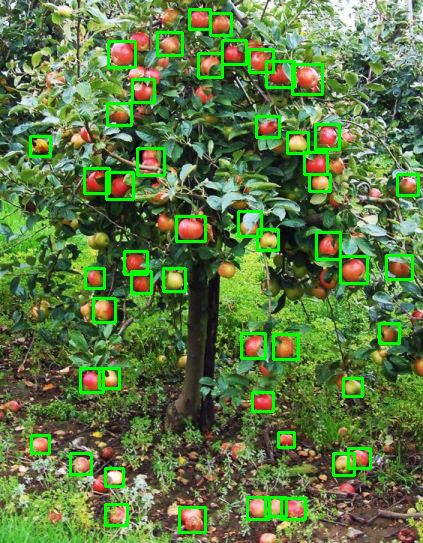

The type is: apple
Number of apples is : 50


In [ ]:
from torchvision.ops import nms
import torch
from collections import Counter

# Assuming `image` and `predictor` are already defined and set up
outputs = predictor(image)
instances = outputs["instances"].to("cpu")

# Convert image to RGB format for visualization if it's not already
if image.shape[2] == 3:  # Check if the image has 3 channels
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
else:
    image_rgb = image  # If it's already RGB or grayscale, no need to convert

# Get the bounding boxes and scores
boxes = instances.pred_boxes.tensor
scores = instances.scores
pred_classes = instances.pred_classes

# Apply NMS
iou_threshold = 0.75  # Intersection Over Union threshold
keep_indices = nms(boxes, scores, iou_threshold)

# Filter boxes, scores, and classes based on NMS
boxes_after_nms = boxes[keep_indices].numpy()
scores_after_nms = scores[keep_indices]
classes_after_nms = pred_classes[keep_indices]

# Draw each bounding box on the image
nb_boxes = 0
for box in boxes_after_nms:
    box = box.astype(np.int32)  # Convert box coordinates from float to int
    cv2.rectangle(image_rgb, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
    nb_boxes +=1

# Convert image back to BGR for displaying with cv2
image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
cv2_imshow( image_bgr)

# Assuming 'types' corresponds to the indices in 'pred_classes'
types = ['apple', 'fraise', 'kiwi', 'lemon', 'orange']

# Count the number of occurrences of each value in classes_after_nms
counts = Counter(classes_after_nms.numpy())
# Find the most common class
most_common_class, most_common_count = counts.most_common(1)[0]
type_fruit = types[most_common_class]

print(f"The type is: {type_fruit}")
print(f"Number of {type_fruit}s is : {nb_boxes}")


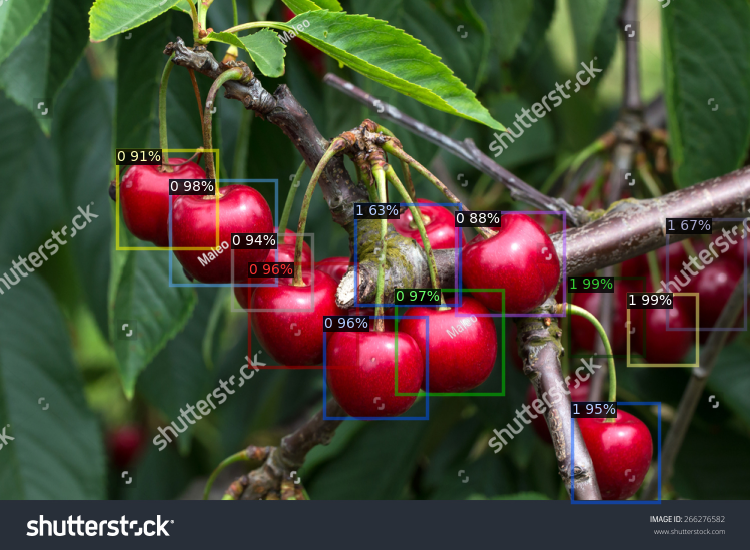

In [ ]:

from torchvision.ops import nms  # Import the NMS function from torchvision
import copy

# Your existing inference code
image3 = image  # Assuming 'image' is your input image
outputs3 = predictor(image3)
metadata = MetadataCatalog.get("dataset_train6")
v2 = Visualizer(image3[:, :, ::-1], metadata=metadata)

# Extracting boxes, scores, and classes from the model's predictions
instances = outputs3["instances"].to("cpu")
boxes = instances.pred_boxes.tensor  # Tensor of shape [N, 4]
scores = instances.scores  # Tensor of shape [N]
classes = instances.pred_classes  # Tensor of shape [N]

# Apply NMS
iou_threshold = 0.5  # You might need to adjust this threshold
keep_indices = nms(boxes, scores, iou_threshold)

# Keep only the instances that were not suppressed by NMS
nms_instances = instances[keep_indices]

# Visualize the results after NMS
out_nms = v2.draw_instance_predictions(nms_instances)

# Display the image with NMS applied
cv2_imshow(out_nms.get_image()[:, :, ::-1])  # Convert from RGB back to BGR for displaying with OpenCV


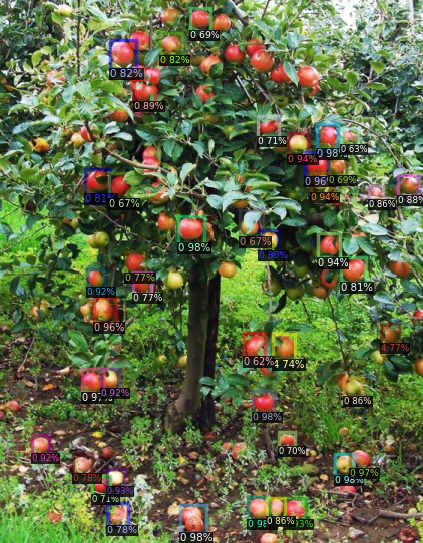

In [ ]:
# We can use `Visualizer` to draw the predictions on the image.
import copy
image2 = copy.deepcopy(image)
outputs1 = predictor(image2)
metadata = MetadataCatalog.get("dataset_train6")
v1 = Visualizer(image2[:, :, ::-1], metadata=metadata)  # Assuming `img` is in BGR format, as read by OpenCV.
out = v1.draw_instance_predictions(outputs1["instances"].to("cpu"))

cv2_imshow(out.get_image()[:, :, ::-1])  # Convert from RGB back to BGR for displaying with OpenCV.

We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~70. Not bad!

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.config import get_cfg

cfg = get_cfg()
evaluator = COCOEvaluator("validation_dataset3", output_dir="/content/drive/MyDrive/P2M/dataset/faster_rcnn_R_50_FPN_3x/more_iterations.yaml")
val_loader = build_detection_test_loader(cfg, "validation_dataset3")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[04/02 01:05:21 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [04/02 01:05:22 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/02 01:05:22 d2.data.datasets.coco]: Loaded 50 images in COCO format from /content/drive/MyDrive/P2M/dataset/val_dataset.json
[04/02 01:05:22 d2.data.build]: Distribution of instances among all 5 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   apple    | 363          |   fraise   | 265          |    kiwi    | 166          |
|   lemon    | 139          |   orange   | 138          |            |              |
|   total    | 1071         |            |              |            |              |
[04/02 01:05:22 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdg

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[04/02 01:05:36 d2.evaluation.evaluator]: Inference done 1/50. Dataloading: 0.6903 s/iter. Inference: 13.2027 s/iter. Eval: 0.0037 s/iter. Total: 13.8979 s/iter. ETA=0:11:20
[04/02 01:05:47 d2.evaluation.evaluator]: Inference done 2/50. Dataloading: 0.3532 s/iter. Inference: 11.9683 s/iter. Eval: 0.0021 s/iter. Total: 12.3266 s/iter. ETA=0:09:51
[04/02 01:05:57 d2.evaluation.evaluator]: Inference done 3/50. Dataloading: 0.2363 s/iter. Inference: 11.1921 s/iter. Eval: 0.0015 s/iter. Total: 11.4324 s/iter. ETA=0:08:57
[04/02 01:06:05 d2.evaluation.evaluator]: Inference done 4/50. Dataloading: 0.1789 s/iter. Inference: 10.3801 s/iter. Eval: 0.0013 s/iter. Total: 10.5626 s/iter. ETA=0:08:05
[04/02 01:06:12 d2.evaluation.evaluator]: Inference done 5/50. Dataloading: 0.1456 s/iter. Inference: 9.7992 s/iter. Eval: 0.0011 s/iter. Total: 9.9487 s/iter. ETA=0:07:27
[04/02 01:06:24 d2.evaluation.evaluator]: Inference done 6/50. Dataloading: 0.0000 s/iter. Inference: 11.8305 s/iter. Eval: 0.0004 s

In [ ]:
!pip install tidecv


-- det_data --

bbox AP @ 50: 72.44

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP     3.30     6.84     0.06     0.00     3.42    10.03  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP       6.97      18.05  



/usr/local/lib/python3.10/dist-packages/tidecv/plotting.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=error_dfs['main'], x='Delta mAP', y='Error Type', ax=ax,
/usr/local/lib/python3.10/dist-packages/tidecv/plotting.py:156: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=error_dfs['special'], x='Error Type', y='Delta mAP', ax=ax,
/usr/local/lib/python3.10/dist-packages/tidecv/plotting.py:161: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['FP', 'FN'])


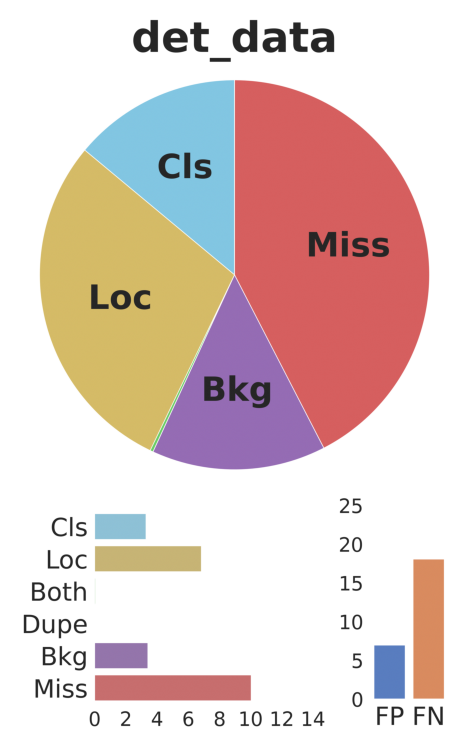

In [ ]:
import json
from tidecv import TIDE, Data

# Assuming cocoGtFile and cocoDtFile are defined paths to your JSON files
with open("/content/drive/MyDrive/P2M/dataset/val_dataset.json") as f:
    gt_json = json.load(f)

with open("/content/drive/MyDrive/P2M/dataset/faster_rcnn_R_50_FPN_3x/more_iterations.yaml/coco_instances_results.json") as f:
    dets_json = json.load(f)

tide = TIDE()

# Initialize Data objects for ground truth and detections
gt_data = Data('gt_data')
det_data = Data('det_data')

# Process ground truth data
for det in gt_json['annotations']:
    image = det['image_id']
    _cls = det['category_id']
    box = det['bbox'] if 'bbox' in det else None
    mask = det['segmentation'] if 'segmentation' in det else None
    gt_data.add_ground_truth(image, _cls, box, mask)

for det in dets_json:  # Directly iterate over dets_json if it's a list
    image = det['image_id']
    _cls = det['category_id']
    score = det['score']
    box = det['bbox']  # No need to check with 'if' since all detections have 'bbox'
    # Add the detection information to det_data
    det_data.add_detection(image, _cls, score, box)


# Evaluate based on bounding boxes
tide.evaluate(gt_data, det_data, mode=TIDE.BOX)

# Summarize and plot the results
tide.summarize()
tide.plot()


-- det_data --

bbox AP @ 50: 74.93

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP     1.93     5.80     0.01     0.00     2.24    12.36  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP       5.07      18.35  



/usr/local/lib/python3.10/dist-packages/tidecv/plotting.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=error_dfs['main'], x='Delta mAP', y='Error Type', ax=ax,
/usr/local/lib/python3.10/dist-packages/tidecv/plotting.py:156: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=error_dfs['special'], x='Error Type', y='Delta mAP', ax=ax,
/usr/local/lib/python3.10/dist-packages/tidecv/plotting.py:161: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['FP', 'FN'])


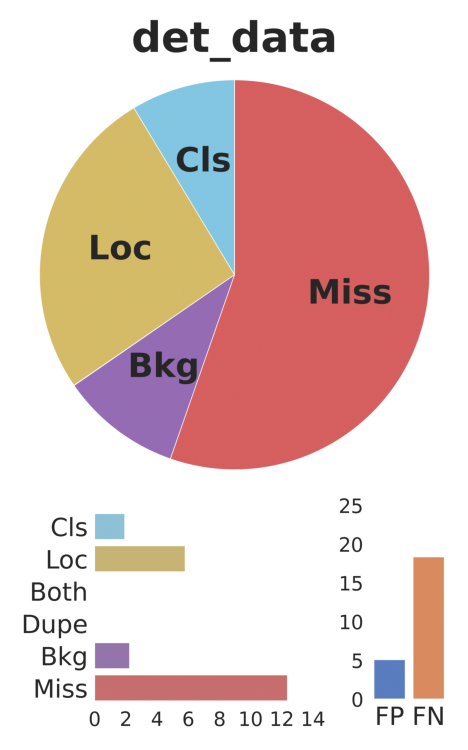

In [ ]:
import json
from tidecv import TIDE, Data

# Assuming cocoGtFile and cocoDtFile are defined paths to your JSON files
with open("/content/drive/MyDrive/P2M/dataset/val_dataset.json") as f:
    gt_json = json.load(f)

with open("/content/drive/MyDrive/P2M/dataset/faster_rcnn_R_50_FPN_3x/coco_instances_results.json") as f:
    dets_json = json.load(f)

tide = TIDE()

# Initialize Data objects for ground truth and detections
gt_data = Data('gt_data')
det_data = Data('det_data')

# Process ground truth data
for det in gt_json['annotations']:
    image = det['image_id']
    _cls = det['category_id']
    box = det['bbox'] if 'bbox' in det else None
    mask = det['segmentation'] if 'segmentation' in det else None
    gt_data.add_ground_truth(image, _cls, box, mask)

for det in dets_json:  # Directly iterate over dets_json if it's a list
    image = det['image_id']
    _cls = det['category_id']
    score = det['score']
    box = det['bbox']  # No need to check with 'if' since all detections have 'bbox'
    # Add the detection information to det_data
    det_data.add_detection(image, _cls, score, box)


# Evaluate based on bounding boxes
tide.evaluate(gt_data, det_data, mode=TIDE.BOX)

# Summarize and plot the results
tide.summarize()
tide.plot()
